In [14]:
"""
This is the starter code and some suggested architecture we provide you with. 
But feel free to do any modifications as you wish or just completely ignore 
all of them and have your own implementations.
"""
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import genfromtxt
import scipy.io
from scipy import stats
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

import csv
import save_csv
import random
random.seed(42)

In [36]:
class DecisionTree:

    def __init__(self, maxdepth, numFeatures):
        """
        TODO: initialization of a decision tree
        """
        self.root = None
        self.maxdepth = maxdepth
        self.numFeatures = numFeatures
        self.predictions = []
             
    def entropy(self, y):
        """
        TODO: implement a method that calculates the entropy given all the labels
        """
        y = np.array(y)
        H = 0
        for i in range(2):
            p = np.count_nonzero(y==i)/len(y)
            H += p * np.log2(p)
        return -H

    
    def information_gain(self, X, y, thresh):
        """
        TODO: implement a method that calculates information gain given a vector of features (X is nx1 column)
        and a split threshold
        """
        H = self.entropy(y)
        X = np.array(X)
        y = np.array(y)
        
        l_index = X < thresh
        r_index = ~l_index
        
        X_l = X[l_index]
        X_r = X[r_index]
        
        y_l = y[l_index]
        y_r = y[r_index]
        
        if len(y_l) == 0 or len(y_r) == 0:
            return 0
        else:
            H_after = (len(y_l) * self.entropy(y_l) + len(y_r) * self.entropy(y_r)) / (len(y_l) + len(y_r))
            return H - H_after
        
    def split(self, X, y, idx, thresh):
        """
        TODO: implement a method that returns a split of the dataset given an index of the feature and
        a threshold for it
        """
        y = np.array(y)
        
        X_transpose = X.T
        feature_col = X_transpose[idx]
        
        l_index = feature_col < thresh
        r_index = ~l_index
           
        X_l = X[l_index] 
        X_r = X[r_index] 
        
        y_l = y[l_index]
        y_r = y[r_index]
        
        return (X_l, y_l, X_r, y_r)
        
    def segmenter(self, X, y):
        """
        TODO: compute entropy gain for all single-dimension splits,
        return the feature and the threshold for the split that
        has maximum gain
        """
        X_transpose = X.T
        information_gains = {} 
        thresholds = []
        features = np.arange(X.shape[1])
        np.random.shuffle(features)
        possibleFeatures = features[:self.numFeatures]
        for j in range(1000):
            for i in possibleFeatures:
                feature_col = X_transpose[i]
                thresh = np.random.choice(feature_col, 1)
                information_gains[self.information_gain(feature_col, y, thresh)] = (i, thresh)
        return information_gains[max(information_gains.keys())]
    
    
    def growTree(self, X, y, depth):
        if len(np.unique(y)) == 1:
            return Leaf(y[0])
        elif depth == self.maxdepth:
            return Leaf(stats.mode(y)[0][0])
        else:
            best_feature, best_threshold = self.segmenter(X, y)
            X_l, y_l, X_r, y_r = self.split(X, y, best_feature, best_threshold)
            if len(y_l) == 0 or len(y_r) == 0:
                return Leaf(stats.mode(y)[0][0])
            return Node((best_feature, best_threshold), self.growTree(X_l, y_l, depth+1), self.growTree(X_r, y_r, depth+1))
            
        
    def fit(self, X, y):
        """
        TODO: fit the model to a training set. Think about what would be 
        your stopping criteria
        """
        self.root = self.growTree(X, y, 0)

    def predict(self, X):
        """
        TODO: predict the labels for input data 
        """
        for point in X:
            self.traverse(self.root, point)
        return self.predictions
    
    def traverse(self, node, test_point):
        if isinstance(node, Leaf):
            #print(node.label)
            self.predictions.append(node.label)
        else:
            if test_point[node.split_rule[0]] < node.split_rule[1]:
               #print("Feature: " + str(node.split_rule[0]) + " < threshold: " + str(node.split_rule[1]))
                self.traverse(node.left, test_point)
            else:
                #print("Feature: " + str(node.split_rule[0]) + " ≥ threshold: " + str(node.split_rule[1]))
                self.traverse(node.right, test_point)
                
    def print_tree(self, node, depth=0):
        if isinstance(node, Node):
            print('%s[feature:%d < %.3f]' % ((depth*' ', (node.split_rule[0]), node.split_rule[1])))
            self.print_tree(node.left, depth+1)
            self.print_tree(node.right, depth+1)
        else:
            print('%s[%s]' % ((depth*' ', node.label)))
            

    def __repr__(self):
        """
        TODO: one way to visualize the decision tree is to write out a __repr__ method
        that returns the string representation of a tree. Think about how to visualize 
        a tree structure. You might have seen this before in CS61A.
        """
        self.print_tree(self.root)

In [37]:
class Node():
    def __init__(self, split_rule, left, right):
        self.split_rule = split_rule #(feature, threshold-value)
        self.left = left
        self.right = right

class Leaf():
    def __init__(self, label):
        self.label = label

In [38]:
class RandomForest():
    
    def __init__(self, numTrees, maxdepth, numFeatures):
        """
        TODO: initialization of a random forest
        """
        self.numTrees = numTrees #number of trees in the random forest
        self.maxdepth = maxdepth       #the depth of each tree in the forest
        self.numFeatures = numFeatures #the number of features we randomly consider on each step to split 
        self.trees = []
        
    def fit(self, X, y):
        """
        TODO: fit the model to a training set.
        """
        for i in range(self.numTrees):
            indices = np.random.randint(X.shape[0], size=X.shape[0])
            X_bootstrapped = X[indices, :]
            y_bootstrapped = y[indices]
            tree = DecisionTree(self.maxdepth, self.numFeatures)
            tree.fit(X_bootstrapped, y_bootstrapped)
            self.trees.append(tree)
    
    def predict(self, X):
        """
        TODO: predict the labels for input data 
        """
        predictions = []
        for tree in self.trees:
            predictions.append(tree.predict(X))
        predictions = np.array(predictions).T
        final_predictions = []
        for row in predictions:
            final_predictions.append(stats.mode(row)[0][0])
        return final_predictions

In [39]:
if __name__ == "__main__":
    dataset = "spam"

    if dataset == "titanic":
        # Load titanic data       
        path_train = 'datasets/titanic/titanic_training.csv'
        X = pd.read_csv(path_train)
        one_hot_class = pd.get_dummies(X["pclass"])
        one_hot_sex = pd.get_dummies(X["sex"])
        one_hot_embarked = pd.get_dummies(X["embarked"])
        X = X.drop("pclass", axis=1).drop("sex", axis=1).drop("embarked", axis=1).drop("cabin", axis=1).drop("ticket", axis=1).drop(705, axis=0)
        X = X.join(one_hot_class).join(one_hot_sex).join(one_hot_embarked)
        X = X.fillna(X.mean())
        
        path_test = 'datasets/titanic/titanic_testing_data.csv'
        Z = pd.read_csv(path_test)
        one_hot_class = pd.get_dummies(Z["pclass"])
        one_hot_sex = pd.get_dummies(Z["sex"])
        one_hot_embarked = pd.get_dummies(Z["embarked"])
        Z = Z.drop("pclass", axis=1).drop("sex", axis=1).drop("embarked", axis=1).drop("cabin", axis=1).drop("ticket", axis=1)
        Z = Z.join(one_hot_class).join(one_hot_sex).join(one_hot_embarked)
        Z = Z.fillna(Z.mean())
        
        y = np.array(X["survived"], int)  # label = survived
        X = X.drop("survived", axis=1)
        X = X.values
        Z = Z.values
        
        class_names = ["Died", "Survived"]
        training_data, val_data, training_labels, val_labels = train_test_split(X, y, test_size=0.25)
        
        
    elif dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription",
            "creative", "height", "featured", "differ", "width", "other",
            "energy", "business", "message", "volumes", "revision", "path",
            "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
            "square_bracket", "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = 'datasets/spam-dataset/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        class_names = ["Ham", "Spam"]
        training_data, val_data, training_labels, val_labels = train_test_split(X, y, test_size=0.2)
    
         
    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)
    
    """
    TODO: train decision tree/random forest on different datasets and perform the tasks 
    in the problem
    """
    classifier = DecisionTree(4, 12) 
    classifier.fit(training_data, training_labels)
    predictions = classifier.predict(val_data)
    accuracy = len([1 for i in range(len(predictions)) if predictions[i] == val_labels[i]]) / len(predictions)

/Users/Adish/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log2
/Users/Adish/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [40]:
y[3]

1

In [41]:
classifier.traverse(classifier.root, X[3])

In [42]:
y[-1]

0

In [43]:
classifier.traverse(classifier.root, X[-1])

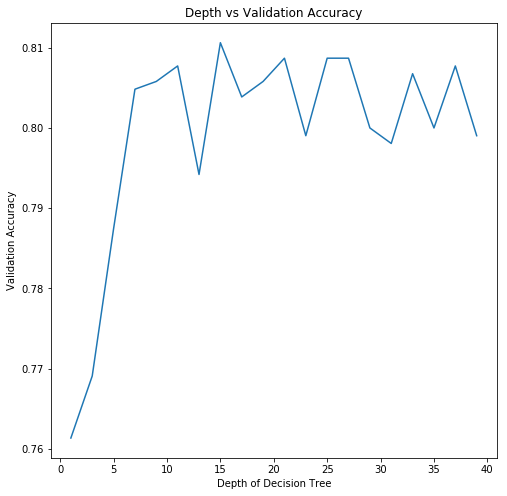

In [15]:
accuracies = []
for depth in np.arange(1, 41, 2):
    classifier = DecisionTree(depth, 12) 
    classifier.fit(training_data, training_labels)
    predictions = classifier.predict(val_data)
    accuracy = len([1 for i in range(len(predictions)) if predictions[i] == val_labels[i]]) / len(predictions)
    accuracies.append(accuracy)
plt.figure(figsize=(8, 8))
plt.title("Depth vs Validation Accuracy")
plt.xlabel("Depth of Decision Tree")
plt.ylabel("Validation Accuracy")
plt.plot(np.arange(1, 41, 2), accuracies)

In [19]:
accuracy

0.788

# Titanic Submission

In [596]:
classifier = RandomForest(7, 7, 12)
classifier.fit(X, y)
predictions = classifier.predict(Z)

/Users/Adish/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log2
/Users/Adish/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [598]:
save_csv.results_to_csv(np.array(predictions))

# Spam Submission 

In [344]:
classifier = DecisionTree(7, 32)
classifier.fit(X, y)
predictions = classifier.predict(Z)

/Users/Adish/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log2
/Users/Adish/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [346]:
save_csv.results_to_csv(np.array(predictions))